In [2]:
import readfof
from pyspark.sql import SparkSession
import numpy as np
import scipy.spatial as SS
from scipy.spatial import KDTree
from visualize_graph import *

In [3]:
spark = SparkSession.builder \
        .master("spark://master:7077")\
        .appName("CosmoSparkApplication")\
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/02 09:56:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/02 09:56:27 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
sc = spark.sparkContext

### Useful functions

In [9]:
# Function to read the data ---> return: [simulation_id, x, y, z, m]
def read_cosmo_data(file_path):

    # Read Fof
    FoF = readfof.FoF_catalog(
        file_path,           # simulation directory
        2,                   # snapnum, indicating the redshift (z=1)
        long_ids = False,
        swap = False,
        SFR = False,
        read_IDs = False
        )

    pos = FoF.GroupPos/1e06             # Halo positions in Gpc/h 
    mass_raw = FoF.GroupMass * 1e10     # Halo masses in Msun/h

    dim = pos.shape[0]
    id = np.arange(dim, dtype=int).reshape(dim, 1)
    pos_mass_matrix = np.hstack([id, pos, mass_raw.reshape(dim, 1)])

    return pos_mass_matrix


# Function to find the cut mass for each simulation ---> return: cut
def find_cut(pos_mass_array, percent):

    return np.quantile(pos_mass_array[:, 4], percent)


# Function to filter the masses according to the mass cut ---> return: [x, y, z, m]
def mass_filter(pos_mass_cut_rdd):

    mass = pos_mass_cut_rdd[0][:, 4]
    cut = pos_mass_cut_rdd[1]

    return pos_mass_cut_rdd[0][mass >= cut, :]

# Function to find the maximum number of partitions available for a certain r_link
def sub_box_number(r_link): 
    cond=False
    box_number=1 # starting number of partitions
    box_length=1.0 # box length in Gpc
    while (cond==False):
        if(box_length/box_number>r_link): # avoids r_link overlapping with the partition length
            box_number+=1
        else:
            cond=True
    return box_number


# Function that returns the partitions bounds as a dictionary of lists of tuples, each tuple being the min and max of a dimension
def sub_box_bounds(box_number,r_link): 
    sub_length=1.0/box_number # partition length
    bounds={}
    base='box'
    sub_box_counter=1
    for x in range(1,box_number):
        for y in range(1,box_number):
            for z in range(1,box_number):
                key=base+str(sub_box_counter)
                single_bounds=[]
                centre=[x,y,z] # vertex of a sub_box corresponding to min x,y,z
                for i in range(3):
                    min_bound=max(0,centre[i]-0.5*r_link)
                    max_bound=min(1,centre[i]+sub_length+0.5*r_link)
                    single_bounds.append((min_bound,max_bound))
                bounds[key]=single_bounds
                sub_box_counter+=1

    return bounds

# Function to assign each point into a box according to its coordinates
def assign_box(point, boxes):
    id, x, y, z, m = point
    box_assign = []
    
    for box_name, ((x_min, x_max), (y_min, y_max), (z_min, z_max)) in boxes.items():
     if (x_min <= x <= x_max) and (y_min <= y <= y_max) and (z_min <= z <= z_max):
           box_assign.append((box_name, point))
    
    return box_assign


# Function to apply KD-tree algorithm to find edges in boxes
def get_edges(pos_mass_points):
    pos_mass_matrix = np.array(pos_mass_points)
    pos = pos_mass_matrix[:,1:4]
    id = pos_mass_matrix[:,0]

    kd_tree = SS.KDTree(pos, leafsize=16, boxsize=1.00001)
    edge_idx = kd_tree.query_pairs(r=0.2, output_type="ndarray")
    edge_idx = np.array([sorted((id[i], id[j])) for i, j in edge_idx])
    
    return edge_idx


# Function to find unique pairs of edges between 2 boxes (pere uniche)
def unique_pears(mat1, mat2):
    mat = np.vstack((mat1, mat2))
    
    return np.unique(mat, axis=0)

In [5]:
# Simulations parameters
sim_pars_file = np.loadtxt("/mnt/cosmo_GNN/latin_hypercube_params.txt", dtype=float)
sim_pars_list = [(i, j) for i, j in enumerate(sim_pars_file)]
sim_pars_file_rdd = sc.parallelize(sim_pars_list)

In [6]:
# Number of simulations to use
N_sims = 100

# path list (key, value)
path_list = [(i, "/mnt/cosmo_GNN/Data/"+str(i)) for i in range(N_sims)]

cosmo_rdd = sc.parallelize(path_list)\
            .mapValues(read_cosmo_data)

In [8]:
# RDD of mass cuts
cut_rdd = cosmo_rdd.mapValues(lambda x: find_cut(x, 0.997))

In [9]:
cut_rdd.take(3)

[(0, np.float64(120789282070723.7)),
 (1, np.float64(205680933863424.0)),
 (2, np.float64(153272484626432.0))]

In [10]:
# Create an unique RDD with 
joined_rdd = cosmo_rdd.join(cut_rdd)

In [11]:
#joined_rdd.take(2)

In [12]:
# Filtered RDD according to the mass values
pos_mass_filtered = joined_rdd.mapValues(mass_filter)

In [13]:
#pos_mass_filtered.take(3)

In [13]:
#pos_mass_filtered.mapValues(assign_node_id).take(1)

In [15]:
# Distribute the simulation key to each point 
cosmo_rdd_filtered = pos_mass_filtered.flatMapValues(lambda x: x)

In [14]:
#cosmo_rdd_filtered.filter(lambda x: x[0] == 1).take(10)

In [15]:
N_boxes = sub_box_number(r_link=0.2)

boxes = sub_box_bounds(3, 0.2)

In [16]:
N_boxes

5

In [17]:
boxes

{'box1': [(0.9, 1), (0.9, 1), (0.9, 1)],
 'box2': [(0.9, 1), (0.9, 1), (1.9, 1)],
 'box3': [(0.9, 1), (1.9, 1), (0.9, 1)],
 'box4': [(0.9, 1), (1.9, 1), (1.9, 1)],
 'box5': [(1.9, 1), (0.9, 1), (0.9, 1)],
 'box6': [(1.9, 1), (0.9, 1), (1.9, 1)],
 'box7': [(1.9, 1), (1.9, 1), (0.9, 1)],
 'box8': [(1.9, 1), (1.9, 1), (1.9, 1)]}

In [16]:
# Create the boxes
min_x, min_y, min_z = 0, 0, 0 # min_coords
max_x, max_y, max_z = 1, 1, 1 # max_coords

# Overlap
r = 0.1  

# Compute the midpoint for every dimension
x_mid = np.mean([min_x, max_x])
y_mid = np.mean([min_y, max_y])
z_mid = np.mean([min_z, max_z])

boxes = {
    "box1": [(min_x    , x_mid + r ), (min_y    , y_mid + r), (min_z    , z_mid + r )],
    "box2": [(x_mid - r, max_x     ), (min_y    , y_mid + r), (min_z    , z_mid + r )],
    "box3": [(min_x    , x_mid + r ), (y_mid - r, max_y    ), (min_z    , z_mid + r )],
    "box4": [(x_mid - r, max_x     ), (y_mid - r, max_y    ), (min_z    , z_mid + r )],
    "box5": [(min_x    , x_mid + r ), (min_y    , y_mid + r), (z_mid - r, max_z    )],
    "box6": [(x_mid - r, max_x     ), (min_y    , y_mid + r), (z_mid - r, max_z    )],
    "box7": [(min_x    , x_mid + r ), (y_mid - r, max_y    ), (z_mid - r, max_z    )],
    "box8": [(x_mid - r, max_x     ), (y_mid - r, max_y    ), (z_mid - r, max_z    )],
}

In [17]:
# Distribute each point into a box
point_box_rdd = cosmo_rdd_filtered.flatMapValues(lambda p: assign_box(p, boxes))

In [18]:
#point_box_rdd.take(3)

In [32]:
#boxes_rdd_sim = point_box_rdd.groupByKey()\
 #                           .mapValues(lambda x: list(x))

In [33]:
#boxes_rdd_sim.take(1)

In [19]:
# Rewrite the key as a tuple (sim_id, box)
boxes_rdd = point_box_rdd.map(lambda x: ((x[0], x[1][0]), x[1][1])).groupByKey()\
                        .mapValues(list)

In [20]:
#boxes_rdd.take(1)

In [21]:
# Apply kd-trees algorithm to retrieve the edges in each box
edges_rdd = boxes_rdd.mapValues(get_edges)

In [22]:
#edges_rdd.take(2)

In [24]:
# Keep only the number of the simulation as a key
rdd_key_sim = edges_rdd.map(lambda x: (x[0][0], x[1]))       

In [25]:
final = rdd_key_sim.reduceByKey(lambda a, b: unique_pears(a, b))

In [32]:
sim = 2 # only simulations 0, 1, 2 work
num = pos_mass_filtered.filter(lambda x: x[0] == sim).keys().take(1)[0]
edge_list = final.filter(lambda x: x[0] == sim).values().take(1)[0]
pos_mas_plot = pos_mass_filtered.filter(lambda x: x[0] == sim).values().take(1)[0][:,1:5]
pars = sim_pars_file_rdd.filter(lambda x: x[0] == sim).values().take(1)[0]

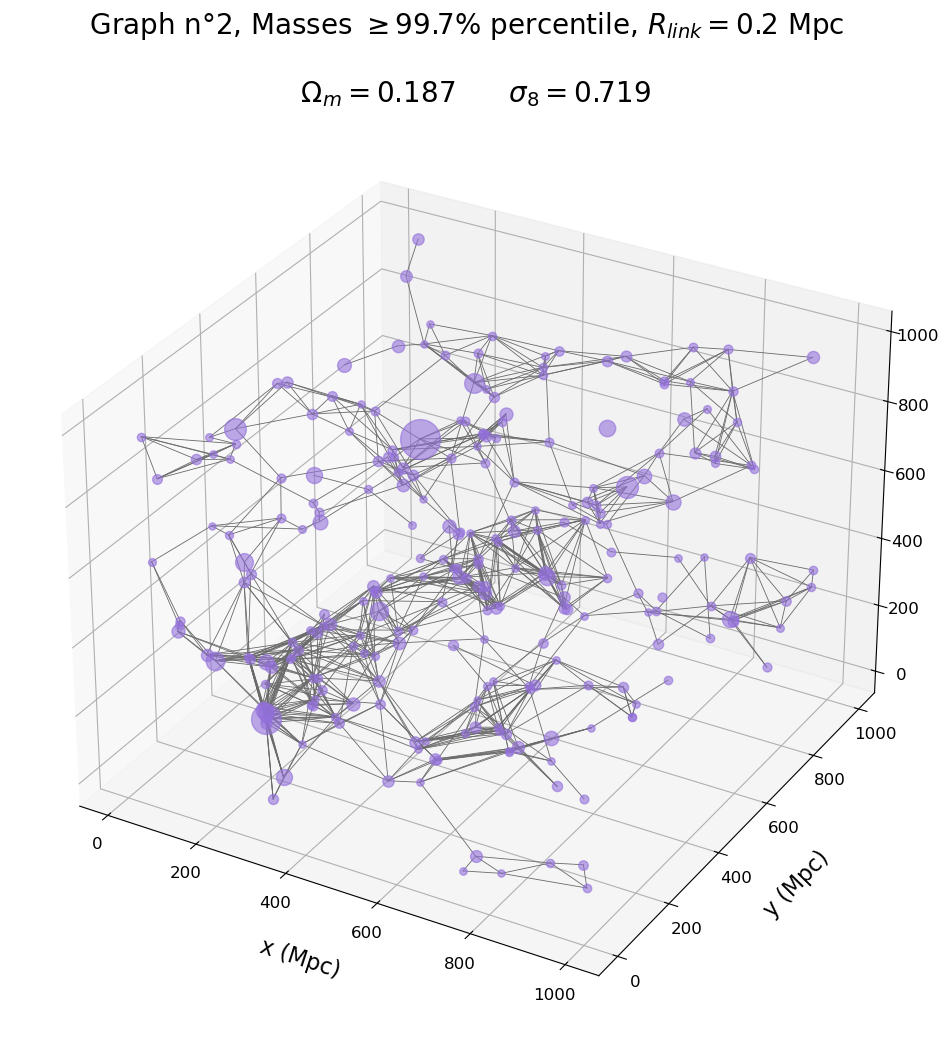

In [33]:
visualize_graph(num, pos_mas_plot, pars, edge_list)

In [91]:
sc.stop()
spark.stop()